# MNIST

In this chapter, we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau

Each image is labeled with the digit it represents. This set has been stud ied so much that it is often called the “Hello World” of Machine Learning: whenever people come up with a new classification algorithm, they are curious to see how it will perform on MNIST

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
#mnist

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:
*   A DESCR key describing the dataset 
*   A data key containing an array with one row per instance and one column per feature
*   A target key containing an array with the labels 


Let’s look at these arrays:

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28x28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black)

Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a array, and display it using Matplotlib’s imshow() function 

(-0.5, 27.5, 27.5, -0.5)

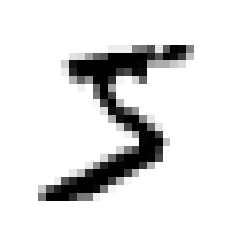

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation='nearest')
plt.axis('off')

This looks like a 5, and indeed that’s what the label tells us:

In [5]:
y[0]

'5'

But wait! You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learn ing algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen

In [7]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task

In [8]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

Okay, now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn's SGDClassifier class. This clas sifier has the advantage of being capable of handling very large datasets efficiently

This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning), as we will see later. Let’s create an SGDClassifier and train it on the whole training set 




In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Now you can use it to detect images of the number 5

In [10]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. There are many performance measures available, so grab another coffee and get ready to learn many new concepts and acronyms!

## Measuring Accuracy Using Cross-Validation

Let’s use the cross_val_score() function to evaluate your SGDClassifier model using K-fold cross-validation, with three folds

Remember that K-fold cross validation means splitting the training set into K-folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9453 , 0.9645 , 0.93365])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn’t it?

Well, before you get too excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

Can you guess this model’s accuracy? Let’s find out

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9095 , 0.9116 , 0.90785])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others)

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confu sion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the cross_val_predict() function 

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training)

Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred) 

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53089,  1490],
       [ 1641,  3780]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class

The first row of this matrix considers non-5 images (the nega tive class): 53,272 of them were correctly classified as non-5s (they are called true negatives), while the remaining 1,307 were wrongly classified as 5s (false positives)

The second row considers the images of 5s (the positive class): 1,077 were wrongly classified as non-5s (false negatives), while the remaining 4,344 were correctly classi fied as 5s (true positives)

A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right)

In [17]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall

In [20]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)


0.7172675521821632

In [21]:
recall_score(y_train_5, y_train_pred)

0.6972883231876038

Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 72% of the time. Moreover, it only detects 70% of the 5s

To compute the F1 score, simply call the f1_score() function

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7071368440744553

## Precision/Recall Tradeof

To understand this tradeoff, let’s look at how the SGDClassifier makes its classifiction decisions

For each instance, it computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’ method, you can call its method, which returns a predict() decision_function() score for each instance, and then make predictions based on those scores using any threshold you want

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2761.08643554])

In [28]:
thershold = 0
y_some_digit_pred = (y_scores > thershold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the predict() method (i.e., True). Let’s raise the threshold 

In [29]:
thershold = 200000
y_some_digit_pred = (y_scores > thershold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually repre sents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 200,000

So how can you decide which threshold to use? For this you will first need to get the scores of all instances in the training set using the cross_val_predict() function again, but this time specifying that you want it to return decision scores instead of predictions

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')

In [45]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

Now with these scores you can compute precision and recall for all possible thresh olds using the precision_recall_curve() function 

In [46]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thersholds = precision_recall_curve(y_train_5, y_scores)

Finally, you can plot precision and recall as functions of the threshold value using
Matplotlib

In [70]:
def plot_precision_recall_vs_thershold(precisions, recalls, thersholds):
  plt.plot(thersholds, precisions[:-1], 'b--', label='Precision')
  plt.plot(thersholds, recalls[:-1], 'g-', label='Recall')
  plt.xlabel('Thershold')
  plt.legend(loc='upper left')
  plt.ylim([0,1])
  plt.xlim([-100000, 45000]) 

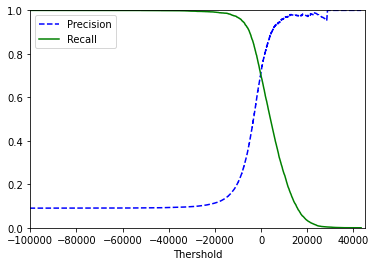

In [71]:
plot_precision_recall_vs_thershold(precisions, recalls, thersholds)
plt.show()

Now you can simply select the threshold value that gives you the best precision/recall tradeoff for your task. Another way to select a good precision/recall tradeoff is to plot precision directly against recall

In [91]:
def plot_precision_versus_recall(precisions, recalls):
  plt.plot(recalls, precisions)
  plt.xlabel('Recall')
  plt.ylabel('Precisions')
  plt.xlim(0, 1)
  plt.ylim(0, 1)

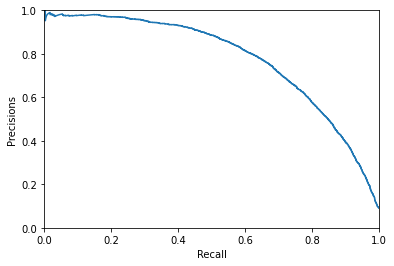

In [92]:
plot_precision_versus_recall(precisions, recalls)

You can see that precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall tradeoff just before that drop—for example, at around 60% recall. But of course the choice depends on your project

So let’s suppose you decide to aim for 90% precision. You look up the first plot (zooming in a bit) and find that you need to use a threshold of about 70,000 (5,000 for this case). To make predictions (on the training set for now), instead of calling the classifier’s predict() method, you can just run this code

In [108]:
y_train_pred_90 = (y_scores > 5000)

Let’s check these predictions’ precision and recall

In [109]:
precision_score(y_train_5, y_train_pred_90)

0.9092585761711546

In [110]:
recall_score(y_train_5, y_train_pred_90)

0.45471315255487915

Great, you have a 90% precision classifier (or close enough)! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. Hmm, not so fast. A high-precision classifier is not very useful if its recall is too low

## The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plot ting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate